#### Magic Commands
Magic commands (those that start with `%`) are commands that modify a configuration of Jupyter Notebooks. A number of magic commands are available by default (see list [here](http://ipython.readthedocs.io/en/stable/interactive/magics.html))--and many more can be added with extensions. The magic command added in this section allows `matplotlib` to display our plots directly on the browser instead of having to save them on a local file.

In [1]:
%matplotlib inline

# Activity 11: Training several models
In this activity, we train our model and two other models (for estimating the prediction interval) before their deployment with Docker.

First, we start by importing `cryptonic`. Cryptonic is a simple software application developed for this course that implements all the steps up to this section using Python classes and modules. Consider Cryptonic a template on how you could develop similar applications.

In [2]:
cd C:/eBooks/Beginning Application Development with TensorFlow and Keras/Lesson-4/activity_9

C:\eBooks\Beginning Application Development with TensorFlow and Keras\Lesson-4\activity_9


In [3]:
import pandas as pd
import matplotlib.pylab as plt
import os
from dotenv import load_dotenv
from pathlib import Path
env_path = Path('.')/'crypto.env'
load_dotenv(dotenv_path=env_path)

True

In [4]:
plt.style.use('seaborn-white')

In [5]:
from cryptonic.models.model import Model
from cryptonic.markets.coinmarketcap import CoinMarketCap

Using TensorFlow backend.
C:\Users\Oleg\Anaconda3\envs\appdev\lib\site-packages\tensorflow\python\framework\dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Oleg\Anaconda3\envs\appdev\lib\site-packages\tensorflow\python\framework\dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Oleg\Anaconda3\envs\appdev\lib\site-packages\tensorflow\python\framework\dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Oleg\Anaconda3\envs\appdev\lib\site-pa

### Fecthing Real-time Data
Throughout this project we have been using data originally provided by [CoinMarketCat](https://coinmarketcap.com/). We have created an interface for collecting both real-time and historical data as as part of `cryptonic`: the class `CoinMarketCap()`.

Our model is designed to work with daily data. Let's go ahead and collect historic daily data from CoinMarketCap (this is the same data used previously).

In [6]:
historic_data = CoinMarketCap.historic(ticker=os.getenv('COIN_TYPE'))

The data contains practically the same variables from our earlier dataset. However, much of the data comes from an earlier period. Recent Bitcoin prices have gained a lot of volatility if compared to the prices of a few years ago. Before using this data in our model, let's make sure to filter it to dates no older than a certain number of most recent weeks.

In [7]:
#  Using the Pandas API, filter the dataframe
from datetime import datetime, timedelta

time_ago = (datetime.now() - timedelta(days=7*int(os.getenv('WEEKS_BACK')))).strftime('%Y-%m-%d')
model_data = historic_data[historic_data['date'] >= time_ago]

In [8]:
model_data.head(5)

,date,open,high,low,close,volume,market_cap
0,2020-01-29,9357.47,9406.43,9269.47,9316.63,30682598115,169460984603
1,2020-01-28,8912.52,9358.59,8908.45,9358.59,34398744403,170205617955
2,2020-01-27,8597.31,8977.73,8597.31,8909.82,28647338393,162027957435
3,2020-01-26,8364.41,8602.40,8325.50,8596.83,22177678796,156322174637
4,2020-01-25,8440.12,8458.45,8296.22,8367.85,19647331549,152143262650


In [9]:
model_data.tail(5)

,date,open,high,low,close,volume,market_cap
275,2019-04-29,5284.86,5311.27,5216.49,5247.35,13735490672,92737510865
276,2019-04-28,5271.75,5326.23,5255.68,5285.14,12819992056,93391244395
277,2019-04-27,5279.47,5310.75,5233.64,5268.29,13111274675,93086156556
278,2019-04-26,5210.30,5383.63,5177.37,5279.35,16812108040,93272287960
279,2019-04-25,5466.52,5542.24,5181.34,5210.52,15330283408,92046492864


### Build and Train Quantile Regression Models

Specify quantiles for quantile regression

In [10]:
# The base model is the one with the 0.5 quantile, while the 0.05 and 0.95 quantile models are lower and upper bounds 
# of the prediction interval
# More more information, read 
# https://medium.com/@qucit/a-simple-technique-to-estimate-prediction-intervals-for-any-regression-model-2dd73f630bcb
quantiles = [0.05, 0.5, 0.95]

Define the custom loss function to be used with different quantiles

In [11]:
# Code below is borrowed from https://towardsdatascience.com/deep-quantile-regression-c85481548b5a
# Rules for writing a custom loss function with parameters are taken from
# https://medium.com/@Bloomore/how-to-write-a-custom-loss-function-with-additional-arguments-in-keras-5f193929f7a0
# These rules must be followed in order for external scripts to correctly load a trained model without the error message
# "Unknown loss function ..."
import keras.backend as K

def tilted_loss(q):
    def loss(y, f):
        """
        q: quantile,
        y: true value,
        f: predicted value
        """

        e = (y - f)
        return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)
    return loss

Build the model by adding layers, optimizer, loss, etc. for each quantile, train it and save it in a file

In [12]:
models = []
quantile_names = ['lower', 'median', 'upper']
for i, quantile in enumerate(quantiles):
    # Initialize the Model class
    M = Model(data=model_data,
              variable='close',
              predicted_period_size=int(os.getenv('PERIOD_SIZE')))
    print('Build and train a model for quantile %.2f ...' % quantile)
    # Specify the loss for a given quantile and build a model
    M.build(loss=tilted_loss(quantile))
    # Train the model
    M.train(epochs=int(os.getenv('EPOCHS')))
    # Save the trained model in a file by appending the proper quantile name to the base model's name
    filename, extension = os.path.splitext(os.getenv('MODEL_NAME'))
    M.save(filename+'_{}'.format(quantile_names[i])+extension)
    # Add the model to the list of model objects for later use in this notebook
    models.append(M)

Build and train a model for quantile 0.05 ...
Build and train a model for quantile 0.50 ...
Build and train a model for quantile 0.95 ...


### Predict one period ahead and plot of historic and predicted values
The graph below shows both historic and predicted values in the same plot. 

In [13]:
def plot_two_series(A, B, variable, title, color, labelA, labelB):
    """
    Plots two series using the same `date` index. 
    
    Parameters
    ----------
    A, B: pd.DataFrame
        Dataframe with a `date` key and a variable
        passed in the `variable` parameter. Parameter A
        represents the "Observed" series and B the "Predicted"
        series. These will be labelled respectivelly. 
    
    variable: str
        Variable to use in plot.
    
    title: str
        Plot title.
        
    LabelA, labelB: str
        Timeseries title.
    
    """
    plt.figure(figsize=(14,7))

    # Concatenate two Data Frames
    C = pd.DataFrame(pd.concat([A, B]))
            
    import numpy as np
    
    ax = C.set_index('date')[variable].iloc[:A.shape[0]].plot(
        xticks=C.index[np.arange(0,C.shape[0],int(os.getenv('PERIOD_SIZE')))],
        linewidth=2, color='#d35400', grid=True, label=labelA, title=title, legend=True, rot=90)
    C = C.reset_index(drop=True)
    C[variable].iloc[A.shape[0]:].plot(
        linewidth=2, color=color, grid=True, label=labelB, legend=True, rot=90, ax=ax)
    
    ax.set_xlabel("Predicted Week")
    ax.set_ylabel("Predicted Cryptocurrency Value")

    plt.show()

Let's now plot the predicted timeseries versus the observed one using the `close` price values.

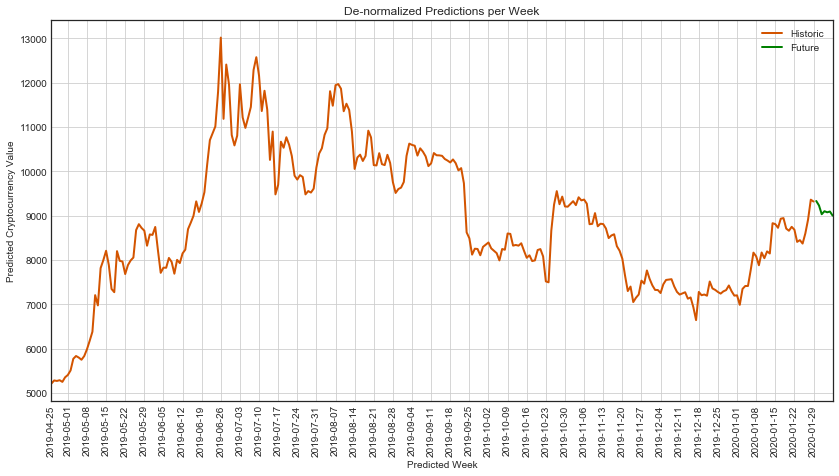

,date,lower prediction,median prediction,upper prediction
0,2020-01-30,9301.01,9328.52,9341.50
1,2020-01-31,9183.71,9227.82,9255.38
2,2020-02-01,9036.72,9030.53,9082.91
3,2020-02-02,9089.61,9098.20,9154.48
4,2020-02-03,9019.04,9073.63,9095.88
5,2020-02-04,9077.91,9091.21,9128.75
6,2020-02-05,8988.93,8997.82,9021.06


In [14]:
# Select only two columns that both historic observations and predictions share in common
# Sort observations from the earliest date to the latest in order to conform with predictions format
historic = model_data[['date', 'close']].sort_values(by=['date'], ascending=True)

colors = ['red', 'green', 'blue']
for i, model in enumerate(models):
    # Make prediction by using a given model
    predictions = model.predict(denormalized=True, return_dict=True)
    # Convert the result to a DataFrame
    predictions = pd.DataFrame(predictions)
    # Rename a column with predictions
    predictions.rename(columns={'prediction': quantile_names[i]+' prediction'}, inplace=True)
    if i == 0:
        # If this is the first time, just store current predictions
        all_predictions = predictions
    else:
        # Otherwise, append the current predictions to the already collected ones
        all_predictions = pd.merge(all_predictions, predictions, on='date')
    if i == 1:
        # Rename the column 'prediction' into 'close' in order to conform with column naming of the original data
        predictions.rename(columns={quantile_names[i]+' prediction': 'close'}, inplace=True)
        # Plot both timeseries
        plot_two_series(historic, predictions, 
                        variable='close',
                        title='De-normalized Predictions per Week',
                        color=colors[i],
                        labelA='Historic',
                        labelB='Future')

# Display predictions for all three models
all_predictions.head(int(os.getenv('PERIOD_SIZE')))

Finally, let us plot one-period-ahead predictions together with the corresponding prediction interval

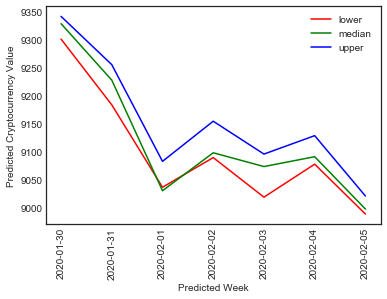

In [15]:
# Plot model predictions for the future period and the prediction interval for these predictions
# Due to the fact that each model is a simple rerun, there is a risk of quantile cross over, i.e. the 50th quantile may go 
# above the 95th quantile
for i, color in enumerate(colors):
    plt.plot(all_predictions['date'], all_predictions[quantile_names[i]+' prediction'], color, label=quantile_names[i])
plt.xticks(rotation='vertical')
plt.xlabel('Predicted Week')
plt.ylabel('Predicted Cryptocurrency Value')
plt.legend()
plt.show()